In [1]:
import pandas as pd 
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

/Users/zhangjunrui/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#读入数据集
print ('loading the dataset...')
df = pd.read_csv('hw1-data.csv' , delimiter = ',')
X = df.values[:,:-1]
y = df.values[: ,-1]

loading the dataset...


In [3]:
#划分训练集和测试集
print ('Split into Train and Test...')
# train_test_split 参数介绍 
## train_test_split(train_data , test_data , test_size , random_state) 
## 其中test_size可选择正整数或者是[0,1]中的浮点数,表示测试集大小
## random_state为随机数种子编号，方便调试
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 100 , random_state = 10)

Split into Train and Test...


In [4]:
def feature_normalization(train , test) : 
    '''
    将每一维特征的数据利用线性变换[0,1]对训练数据和测试数据归一化,其中统计量来自于训练数据.
    Args:
        train - training set , 二维numpy数组(num_instances , num_features)
        test - test set , 二维numpy数组(num_instances , num_features)
    
    Returns:
        train_normalized - training set after normalization 
        test_normalized - test set after normalization
    '''
    mean = np.mean(train , axis = 0)
    std = np.std(train , axis = 0)
    try :
        Max = np.max(train , axis = 0)
        Min = np.min(train , axis = 0)
        #这个地方的减法运用了广播机制,考虑后缘维度(从末尾开始算起的维度)的轴长度相同,或者其中的一方长度为1.
        train_normalized = (train - Min) / (Max - Min)
        test_normalized = (test - Min) / (Max - Min)
    except ValueError :
        print ('There maybe some features are exactly same !')
    return train_normalized , test_normalized

In [5]:
#归一化
print ('Scaling all to [0,1]')
X_train , X_test = feature_normalization(X_train , X_test)
#添加偏置项 Add bias term
## np.hstack函数用来横向堆叠   np.hstack([arr1 , arr2])   要求arr1和arr2都是相同维数的矩阵,比如二维矩阵.然后其中行数要相同
## np.vstack函数用来纵向堆叠
X_train = np.hstack((X_train , np.ones([X_train.shape[0] , 1])))
X_test = np.hstack((X_test , np.ones([X_test.shape[0] , 1])))

Scaling all to [0,1]


In [6]:
def compute_square_loss(X , y , theta) :
    '''
    给定X,y,theta,计算用X*theta作为y预测的平方损失   loss = |X * theta - y|^2 / m
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
    Returns:
        loss - 平方损失 , 标量
    '''
    #这里用到了np.matmul的一些性质 y_ = X * theta.T
    #np.matmul(X,theta) = np.matmul(X,theta.T)
    y_ = np.matmul(X , theta)
    #print (y_)
    loss = np.mean((y_ - y) ** 2) / 2
    return loss

In [7]:
def compute_square_loss_gradient(X , y , theta) :
    ''' 
    计算平方损失函数关于参数theta的梯度   grad = X^T * (X * theta - y) / m
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
    Returns:
        grad - 梯度向量 , 一维numpy数组(num_features)
    '''
    num_instances = X.shape[0]
    grad = np.matmul(X.T  , np.matmul(X , theta) - y) / num_instances
    return grad

In [8]:
theta = np.ones(X_train.shape[1])
loss = compute_square_loss(X_train , y_train , theta)
grad = compute_square_loss_gradient(X_train , y_train , theta)

In [9]:
x = np.array([[1,2,3],[4,5,6]])
w = np.array([1,2,3])
print (np.matmul(x , w))
print (np.matmul(x , w.T))

[14 32]
[14 32]


In [10]:
def gradient_check(X , y , theta , epsilon = 0.01 , tolerance = 1e-4) :
    '''
    利用梯度的定义近似计算梯度，以检验compute_square_loss_gradient函数计算的梯度是否正确
    设d表示特征维度(包括了bias term),e_1=(1,0,...,0),e_2=(0,1,0,...,0),...,e_d=(0,0,...,0,1)
    近似梯度可以通过如下公式计算,其第i个分量可以表示为
        J(theta + epsilon * e_i) - J(theta - epsilon * e_i) / (2 * epsilon)
    之后考虑计算真实梯度和近似梯度的欧几里得距离来验证计算是否正确
    
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
        epsilon - 近似时使用的单位方向上的步长参数
        tolerance - 允许误差
    
    Returns:
        一个布尔值 , 表示计算是否正确
    '''
    true_grad = compute_square_loss_gradient(X , y , theta)
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features)
    I = np.identity(num_features)
    for i in range(num_features) :
        delta = I[i] * epsilon
        approx_grad[i] = (compute_square_loss(X , y , theta + delta) - compute_square_loss(X , y , theta - delta))/ (2 * epsilon)
    dis = np.mean((true_grad - approx_grad)**2)
    return (dis < tolerance)

In [11]:
gradient_check(X_train , y_train , theta)

True

In [12]:
def generic_gradient_check(X , y , theta , objective_func , gradient_func , epsilon = 0.01 , tolerance = 1e-4) :
    '''
    一般情形的梯度检验函数
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
        objective_func - 目标函数的函数,返回目标值loss
        gradient_func - 梯度公式函数,返回梯度
        epsilon - 近似时使用的单位方向上的步长参数
        tolerance - 允许误差
    Returns:
        一个布尔值 , 表示计算是否正确
    '''
    true_grad = gradient_func(X , y , theta)
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features)
    ind = np.identity(num_features)
    for i in range(num_features) :
        delta = ind[i]
        approx_grad[i] = (objective_func(X , y , theta + epsilon * delta) - objective_func(X , y , theta - epsilon * delta)) / (2 * epsilon)
    dis = np.mean((true_grad - approx_grad)**2)
    return (dis < tolerance)

In [13]:
def batch_grad_descent(X , y , alpha = 0.01 , num_iter = 1000 , check_gradient = False) :
    '''
    利用梯度下降法求解平方损失函数的线性模型的参数
    
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        alpha - 学习率/梯度步长 , 标量
        num_iter - 最大迭代次数 , 标量
        check_gradient - 是否进行梯度计算检验 , 布尔值
    Returns:
        theta_hist - 迭代过程中储存的参数列表 , 二维numpy数组(num_iter + 1 , num_features) , 其中 theta_hist[0]为初始参数, 
                     theta_hist[-1]为迭代结束时的参数
        loss_hist - 迭代过程中储存的loss列表,一维numpy数组(num_iter + 1)
    '''
    [num_instances , num_features] = X.shape
    theta_hist = np.zeros((num_iter + 1 , num_features))  #初始化参数列表
    loss_hist = np.zeros(num_iter + 1)
    theta = np.ones(num_features)
    
    theta_hist[0] = theta
    loss_hist[0] = compute_square_loss(X , y , theta)
    
    for i in range(num_iter) :
        if (check_gradient == True) :
            if (gradient_check(X , y , theta) == False) :
                return False
        theta = theta - alpha * compute_square_loss_gradient(X , y , theta)
        theta_hist[i + 1] = theta
        loss_hist[i + 1] = compute_square_loss(X , y , theta)
    
    return theta_hist , loss_hist

In [14]:
theta_hist , loss_hist = batch_grad_descent(X_train , y_train)
#print (loss_hist[-1])

In [15]:
def Experiment1(X_train , y_train , X_test , y_test) :
    '''
    实验一主要讨论了学习率以及迭代次数对于模型收敛性的影响
    现象：1.当学习率过大时,模型难以收敛
         2.当学习率较小并且轮数较多的时候,虽然在training set上的loss减小,但是test set上的loss反而增加
    '''
    alpha_list = [0.1 , 0.05 ,0.01 , 0.005]
    color_list = ['G' , 'B' , 'R' , 'Y']
    #plt.figure(figsize = (16 , 16))
    num_iter = 2000
    step_size = 100
#     plt.xlim(0 , num_iter)
#     plt.ylim(0 , 5)
    for i in range(len(alpha_list)) :
        theta_hist , loss_hist = batch_grad_descent(X_train , y_train , alpha = alpha_list[i] , num_iter = num_iter)
        x_cord = [step_size * i for i in range(int(num_iter / step_size) + 1)]
        y_cord = [loss_hist[step_size * i] for i in range(int(num_iter / step_size) + 1)]
        #plt.plot(x_cord , y_cord , label = 'alpha = '+  str(alpha_list[i]) , color = color_list[i])
        #print (i , 'train_error =' , loss_hist[-1] , ', test_error =' , compute_square_loss(X_test , y_test , theta_hist[-1]))
    #plt.show()
Experiment1(X_train , y_train , X_test , y_test)

In [16]:
def batch_grad_descent_Backtracking_line_search(X , y , num_iter = 1000 , gamma = 0.5 , epsilon = 0.25) :
    '''
    利用回溯线性搜索方法优化的梯度下降法,原来是每一次迭代中,先求出梯度下降方向,然后为了不一次越界,考虑找到一个合理的最大步长t*grad,
                            这个t应该满足while循环里的条件 L(theta - t * grad) <= L(theta) - epsilon * <t * grad , grad>
                                                                            = L(theta) - epsilon * t * |grad|^2
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        num_iter - 最大迭代次数 , 标量
        gamma - 回溯时使用的放缩参数 , 标量 , 0 < gammar < 1
        epsilon - 搜索停止参数 , 标量
    Returns:
        theta_hist - 迭代过程中储存的参数列表 , 二维numpy数组(num_iter + 1 , num_features) , 其中 theta_hist[0]为初始参数, 
                     theta_hist[-1]为迭代结束时的参数
        loss_hist - 迭代过程中储存的loss列表,一维numpy数组(num_iter + 1)
    '''
    [num_instances , num_features] = X.shape
    theta_hist = np.zeros((num_iter + 1 , num_features))
    loss_hist = np.zeros(num_iter + 1)
    theta = np.ones(num_features)
    loss = compute_square_loss(X , y , theta)
    
    theta_hist[0] = theta
    loss_hist[0] = loss
    
    for i in range(num_iter) :
        grad = compute_square_loss_gradient(X , y , theta)
        square_grad = np.sum(grad * grad)
        t = 1.0
        while ((compute_square_loss(X , y , theta - t * grad)) > (loss - epsilon * t * square_grad)) :
            t = t * gamma
        theta = theta - t * gamma * grad
        loss = compute_square_loss(X , y , theta)
        theta_hist[i + 1] = theta
        loss_hist[i + 1] = loss
    return theta_hist , loss_hist

In [17]:
def Experiment2(X_train , y_train , X_test , y_test) :
    '''
    实验二讨论了朴素的梯度下降法和利用回溯线性搜索优化的梯度下降法的效率问题,发现后者可以更快更好地收敛.
    '''
    theta_hist , loss_hist = batch_grad_descent_Backtracking_line_search(X_train , y_train , num_iter = 200)
    print (loss_hist[-1])
    theta_hist , loss_hist = batch_grad_descent(X_train , y_train , num_iter = 200 , alpha = 0.1)
    print (loss_hist[-1])
Experiment2(X_train , y_train , X_test , y_test)

1.18220359532076
1.477647851866748


In [18]:
def compute_regularized_square_loss(X , y , theta , lambda_reg = 1 , B = 0) :
    '''
    带正则的线性模型的平方损失函数  loss = |X * theta - y|^2 / m + lambda_reg * |theta|^2 + (B - 1) * theta[-1]^2
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
        lambda_reg - 正则化项系数 , 标量
        B - 消除bias term的正则化影响 , 标量  
    Returns:
        loss - 平方损失 , 标量
    '''
    y_ = np.matmul(X , theta)
    square_loss = np.mean((y - y_) ** 2) / 2
    reg_loss = lambda_reg * np.sum((theta) ** 2)
    reg_loss += (B - 1) * lambda_reg * theta[-1] * theta[-1]
    loss = square_loss + reg_loss
    return loss

In [19]:
# 在解决回归问题时,不该对bias term加正则约束,因此需要调整.
         #一种方法是在生成额外特征时的1可以换成一个充分大的B
         #第二种方法在计算loss和grad的时候修改掉
        
def compute_regularized_square_loss_gradient(X , y , theta , lambda_reg = 1 , B = 0) :
    ''' 
    计算平方损失函数关于参数theta的梯度   grad = X^T * (X * theta - y) / m + 2 * lambda_reg * (theta - (0,0,...,theta[-1]))
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        theta - 模型参数数据 , 一维numpy数组(num_features)
        lambda_reg - 正则化系数 , 标量
        B - 消除bias term的正则化影响 , 标量
    Returns:
        grad - 梯度向量 , 一维numpy数组(num_features)
    '''
    num_instances = X.shape[0]
    y_ = np.matmul(X , theta)
    grad_square = np.matmul(X.T , (y_ - y)) / num_instances
    grad_reg = 2 * lambda_reg * theta
    grad_reg[-1] += 2 * (B - 1) * lambda_reg * theta[-1]
    grad = grad_square + grad_reg
    return grad

In [20]:
# print (compute_square_loss(X_train , y_train , theta))
# print (compute_regularized_square_loss(X_train , y_train , theta , lambda_reg = 0))
theta = np.ones(X_train.shape[1])
#print (compute_regularized_square_loss_gradient(X_train , y_train , theta))
generic_gradient_check(X_train , y_train , theta , compute_regularized_square_loss , compute_regularized_square_loss_gradient)

True

In [21]:
def stochastic_grad_descent(X , y , alpha = 0.0001 , lambda_reg = 1 ,
                            num_iter = 1000 , B = 0 , 
                            objective_func = compute_regularized_square_loss , 
                            gradient_func = compute_regularized_square_loss_gradient):
    '''
    利用随机梯度梯度下降法求解平方损失函数的线性模型的参数,每一轮中都要对数据进行一次shuffle,然后只用一个样本数据进行梯度更新
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        alpha - 学习率/梯度步长 , 标量
        lambda_reg - 正则化系数 , 标量
        num_iter - 最大迭代轮数 , 标量
        B - 消除bias term的正则化影响 , 标量
        objective_func - 损失函数 , 函数
        gradient_func - 损失函数对应的梯度函数 , 函数
    Returns:
        theta_hist - 迭代过程中储存的参数列表 , 三维numpy数组(num_iter , num_instances , num_features)
        loss_hist - 迭代过程中储存的loss列表,二维numpy数组(num_iter , num_instances)
    '''
    [num_instances , num_features] = X.shape
    theta = np.ones(num_features)
    loss = objective_func(X , y , theta , lambda_reg , B)
    index = np.array(range(num_instances))
    theta_hist = np.zeros((num_iter , num_instances , num_features))
    loss_hist = np.zeros((num_iter , num_instances))
    
    for i in range(num_iter) :
        np.random.shuffle(index)
        for j in range(num_instances) :
            X_feed = X[index[j]].reshape(1 , -1)
            y_feed = np.array(y[index[j]])
            grad = gradient_func(X_feed , y_feed , theta , lambda_reg , B)
            theta -= alpha * grad
            loss = objective_func(X , y  , theta , lambda_reg , B)
            theta_hist[i][j] = theta
            loss_hist[i][j] = loss
    return theta_hist , loss_hist
    

In [22]:
theta_hist , loss_hist = stochastic_grad_descent(X_train , y_train , 
                                                 objective_func = compute_regularized_square_loss ,
                                                 gradient_func = compute_regularized_square_loss_gradient)
print (loss_hist[-1])

[3.67599942 3.67598473 3.67599073 3.67598571 3.67600233 3.67598994
 3.67600427 3.67603785 3.67601764 3.6760163  3.67601886 3.67599824
 3.67599755 3.67599555 3.6759953  3.67604739 3.67604207 3.6760073
 3.67602109 3.67599872 3.67599539 3.67600455 3.67602282 3.67600646
 3.67600307 3.67601024 3.67601166 3.67603189 3.67602293 3.67602311
 3.67602275 3.6760278  3.67626602 3.67610455 3.67636858 3.6763866
 3.67662429 3.67731943 3.67716872 3.67722767 3.67715922 3.67680824
 3.67683083 3.67691928 3.67724894 3.67698208 3.67697392 3.67704509
 3.67709049 3.67716226 3.67750709 3.67754151 3.67752929 3.67755208
 3.6774084  3.67725317 3.67729911 3.67732175 3.67732174 3.67775465
 3.67758349 3.67755121 3.67751839 3.67749922 3.67703268 3.67705371
 3.67661579 3.67655073 3.67631537 3.67642347 3.67643017 3.6765416
 3.67646577 3.67635487 3.67636874 3.67643026 3.67623343 3.67626111
 3.67612328 3.67618724 3.67635794 3.67629513 3.67636401 3.67604694
 3.67605562 3.67606221 3.67607234 3.67598348 3.67610507 3.6759712

In [23]:
def adaptive_learning_rate_stochastic_grad_descent(X , y , alpha = 0.01 , lambda_reg = 1 , num_iter = 1000 , B = 0 , 
                                                  objective_func = compute_regularized_square_loss , 
                                                  gradient_func = compute_regularized_square_loss_gradient):
    '''
    利用随机梯度梯度下降法求解平方损失函数的线性模型的参数,每一轮中都要对数据进行一次shuffle,然后只用一个样本数据进行梯度更新,
    学习率会随着迭代次数增加而逐渐减小,有1/t和1/sqrt(t)两种衰减方式
    Args:
        X - 输入特征数据 , 二维numpy数组(num_instances , num_features)
        y - 标签label数据 , 一维numpy数组(num_instances)
        alpha - 初始学习率/梯度步长 , 标量
        lambda_reg - 正则化系数 , 标量
        num_iter - 最大迭代轮数 , 标量
        B - 消除bias term的正则化影响 , 标量
        objective_func - 损失函数 , 函数
        gradient_func - 损失函数对应的梯度函数 , 函数
    Returns:
        theta_hist - 迭代过程中储存的参数列表 , 三维numpy数组(num_iter , num_instances , num_features)
        loss_hist - 迭代过程中储存的loss列表,二维numpy数组(num_iter , num_instances)
    '''
    [num_instances , num_features] = X.shape
    theta = np.ones(num_features)
    loss = objective_func(X , y , theta , lambda_reg , B)
    index = np.array(range(num_instances))
    theta_hist = np.zeros((num_iter , num_instances , num_features))
    loss_hist = np.zeros((num_iter , num_instances))
    
    for t in range(num_iter) :
        np.random.shuffle(index)
        for i in range(num_instances) :
            X_feed = X[index[i]].reshape(1 , -1)
            y_feed = np.array(y[index[i]])
            beta = alpha / np.sqrt(t + 1)
            grad = gradient_func(X_feed , y_feed , theta , lambda_reg , B)
            theta -= beta * grad
            loss = objective_func(X , y  , theta , lambda_reg , B)
            theta_hist[t][i] = theta
            loss_hist[t][i] = loss
    return theta_hist , loss_hist

In [24]:
theta_hist , loss_hist = adaptive_learning_rate_stochastic_grad_descent(X_train , y_train)
print (loss_hist[-1][-1])

3.6753688522707417


In [49]:
def Experiment3(X_train , y_train , X_test , y_test) :
    '''
    实验三讨论了BGD和SGD的收敛效率和稳定性的区别.从图中可以看出,SGD迅速下降到局部最优解附近,且反复震荡.
    '''
    plt.figure(figsize = (16 , 16))
    num_iter = 20000
    step_size = 200
    plt.xlim(0 , num_iter)
    plt.ylim(0 , 1)
    theta_hist , loss_hist = batch_grad_descent(X_train , y_train , alpha = 0.01 , num_iter = num_iter)
    #print (loss_hist[-1])
    x_cord = [step_size * i for i in range(int(num_iter / step_size))]
    y_cord = [np.log10(loss_hist[step_size * i + 1]) for i in range(int(num_iter / step_size))]
    plt.plot(x_cord , y_cord , color = 'G')
    theta_hist , loss_hist =stochastic_grad_descent(X_train , y_train , alpha = 0.01 , lambda_reg = 0 , B = 0 , num_iter = num_iter)
    #print (loss_hist[-1][-1])
    y_cord = [np.log10(loss_hist[step_size * i][-1]) for i in range(int(num_iter / step_size))]
    plt.plot(x_cord , y_cord , color = 'R')
    plt.show()
    
    

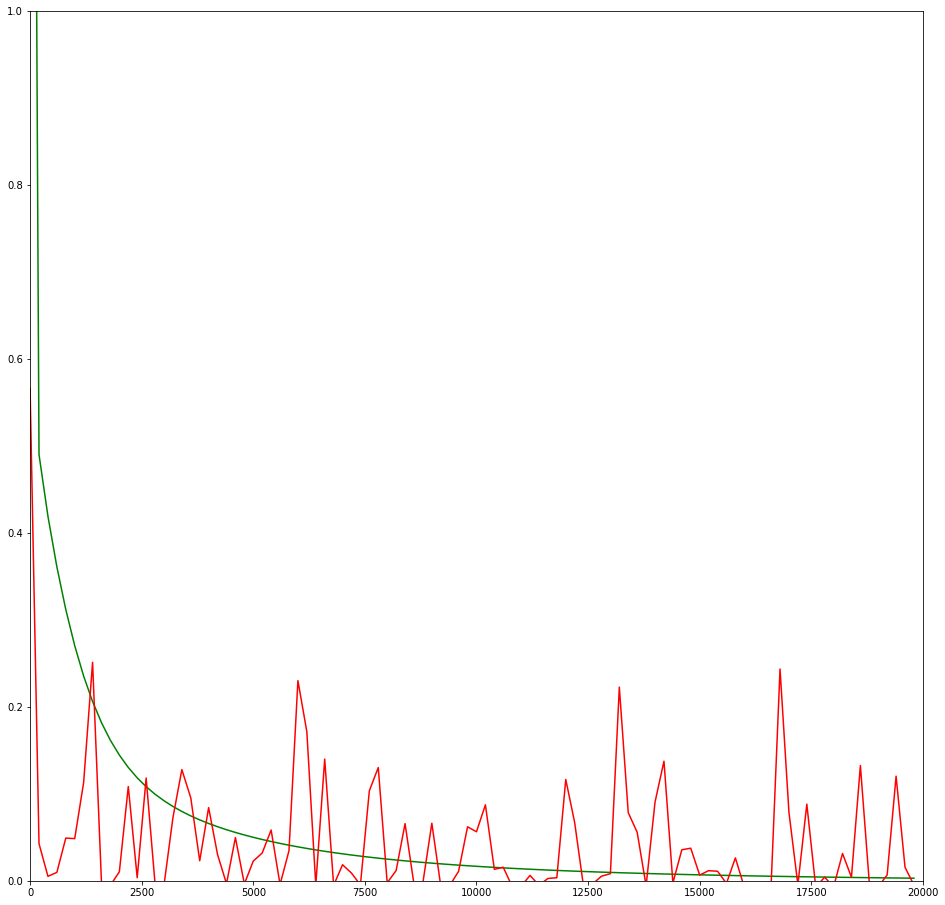

In [50]:
Experiment3(X_train , y_train , X_test , y_test)
